<a href="https://colab.research.google.com/github/darkhorseAnkit/AI-Driven-Yolo-Model-Training/blob/main/VegetationSegmentationYolov8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
!pip install ultralytics rasterio opencv-python scikit-learn albumentations matplotlib torch torchvision earthengine-api geopandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 53.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 69.5 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')  # If stored in Google Drive

# If uploaded manually
!unzip "/content/drive/MyDrive/vegetationsegmentation.v4i.yolov8.zip" -d /content/dataset

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Archive:  /content/drive/MyDrive/vegetationsegmentation.v4i.yolov8.zip
 extracting: /content/dataset/README.dataset.txt  
 extracting: /content/dataset/README.roboflow.txt  
 extracting: /content/dataset/data.yaml  
   creating: /content/dataset/test/
   creating: /content/dataset/test/images/
 extracting: /content/dataset/test/images/0-0-32_png.rf.0bd2c3beb0b6e72afb744be39011a4b2.jpg  
 extracting: /content/dataset/test/images/0-1-14_png.rf.571ebae03cd52ceac7ac1beee7c4e52e.jpg  
 extracting: /content/dataset/test/images/0-1-4_png.rf.52706a8121e702d22fe4b744ad603a5e.jpg  
 extracting: /content/dataset/test/images/0-13-15_png.rf.a87017e74e06c80c5cb466c08da01027.jpg  
 extracting: /content/dataset/test/images/0-13-37_png.rf.24fecf374abb8e9bf3c69fcd642b4814.jpg  
 extracting: /content/dataset/test/images/0-16-57_png.rf.9295fea2ea6d847a1fcf4817aa6190f8.jpg  
 ext

In [3]:
import os

for split in ["train", "valid", "test"]:
    path = f"/content/dataset/{split}/images"
    if os.path.exists(path):
        print(split, "->", os.listdir(path)[:5])
    else:
        print(f"{split} folder not found at {path}")

train -> ['0-33-18_png.rf.4b99d86be53670630c1492c3ac685ace.jpg', '0-16-12_png.rf.a1462213c553d35765ae131f26e28cca.jpg', '0-27-38_png.rf.d79643a3c32ff0bfdd11dc49a15cb5b0.jpg', '0-75-53_png.rf.a35caafaffde29fd8bcccbc1ae4b02ab.jpg', '0-4-44_png.rf.d7ea9deddd6d65c0b5da205fac010231.jpg']
valid -> ['0-27-5_png.rf.803e5e62b74f342d5a59188656c21077.jpg', '0-62-6_png.rf.31627587da37cb7e3592c08443387d08.jpg', '1-36-22_png.rf.7c9b72a0447b5c0333ee7ef4551bbf25.jpg', '0-34-59_png.rf.64c301d12227c619d19772c462f17f53.jpg', '1-21-8_png.rf.66a00f58789364926c67ef3df5138f8b.jpg']
test -> ['2-8-7_png.rf.641c33946a51ab6a63aa931a6cb261f4.jpg', '1-33-13_png.rf.45d6f3fa4b3cb6f7b42eaa83bdc520c0.jpg', '3-5-0_png.rf.2b21b5a43f0d73c587450e28d68c0d81.jpg', '1-21-8_png.rf.e6ed145f70469b21391159b925246667.jpg', '0-59-18_png.rf.d76c2e379d6b3a850db225cb706436cf.jpg']


# View & Visualize Sample Images

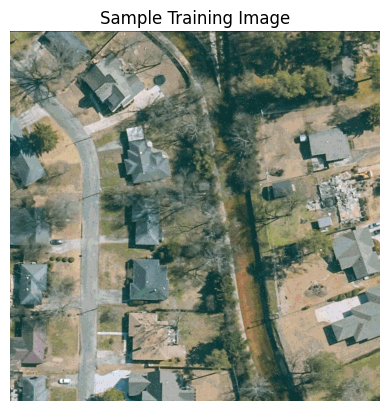

In [6]:
import cv2, matplotlib.pyplot as plt, random

train_path = "/content/dataset/train/images"
sample_img = os.path.join(train_path, random.choice(os.listdir(train_path)))

img = cv2.imread(sample_img)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img_rgb)
plt.title("Sample Training Image")
plt.axis("off")
plt.show()

# Preprocessing Pipelines

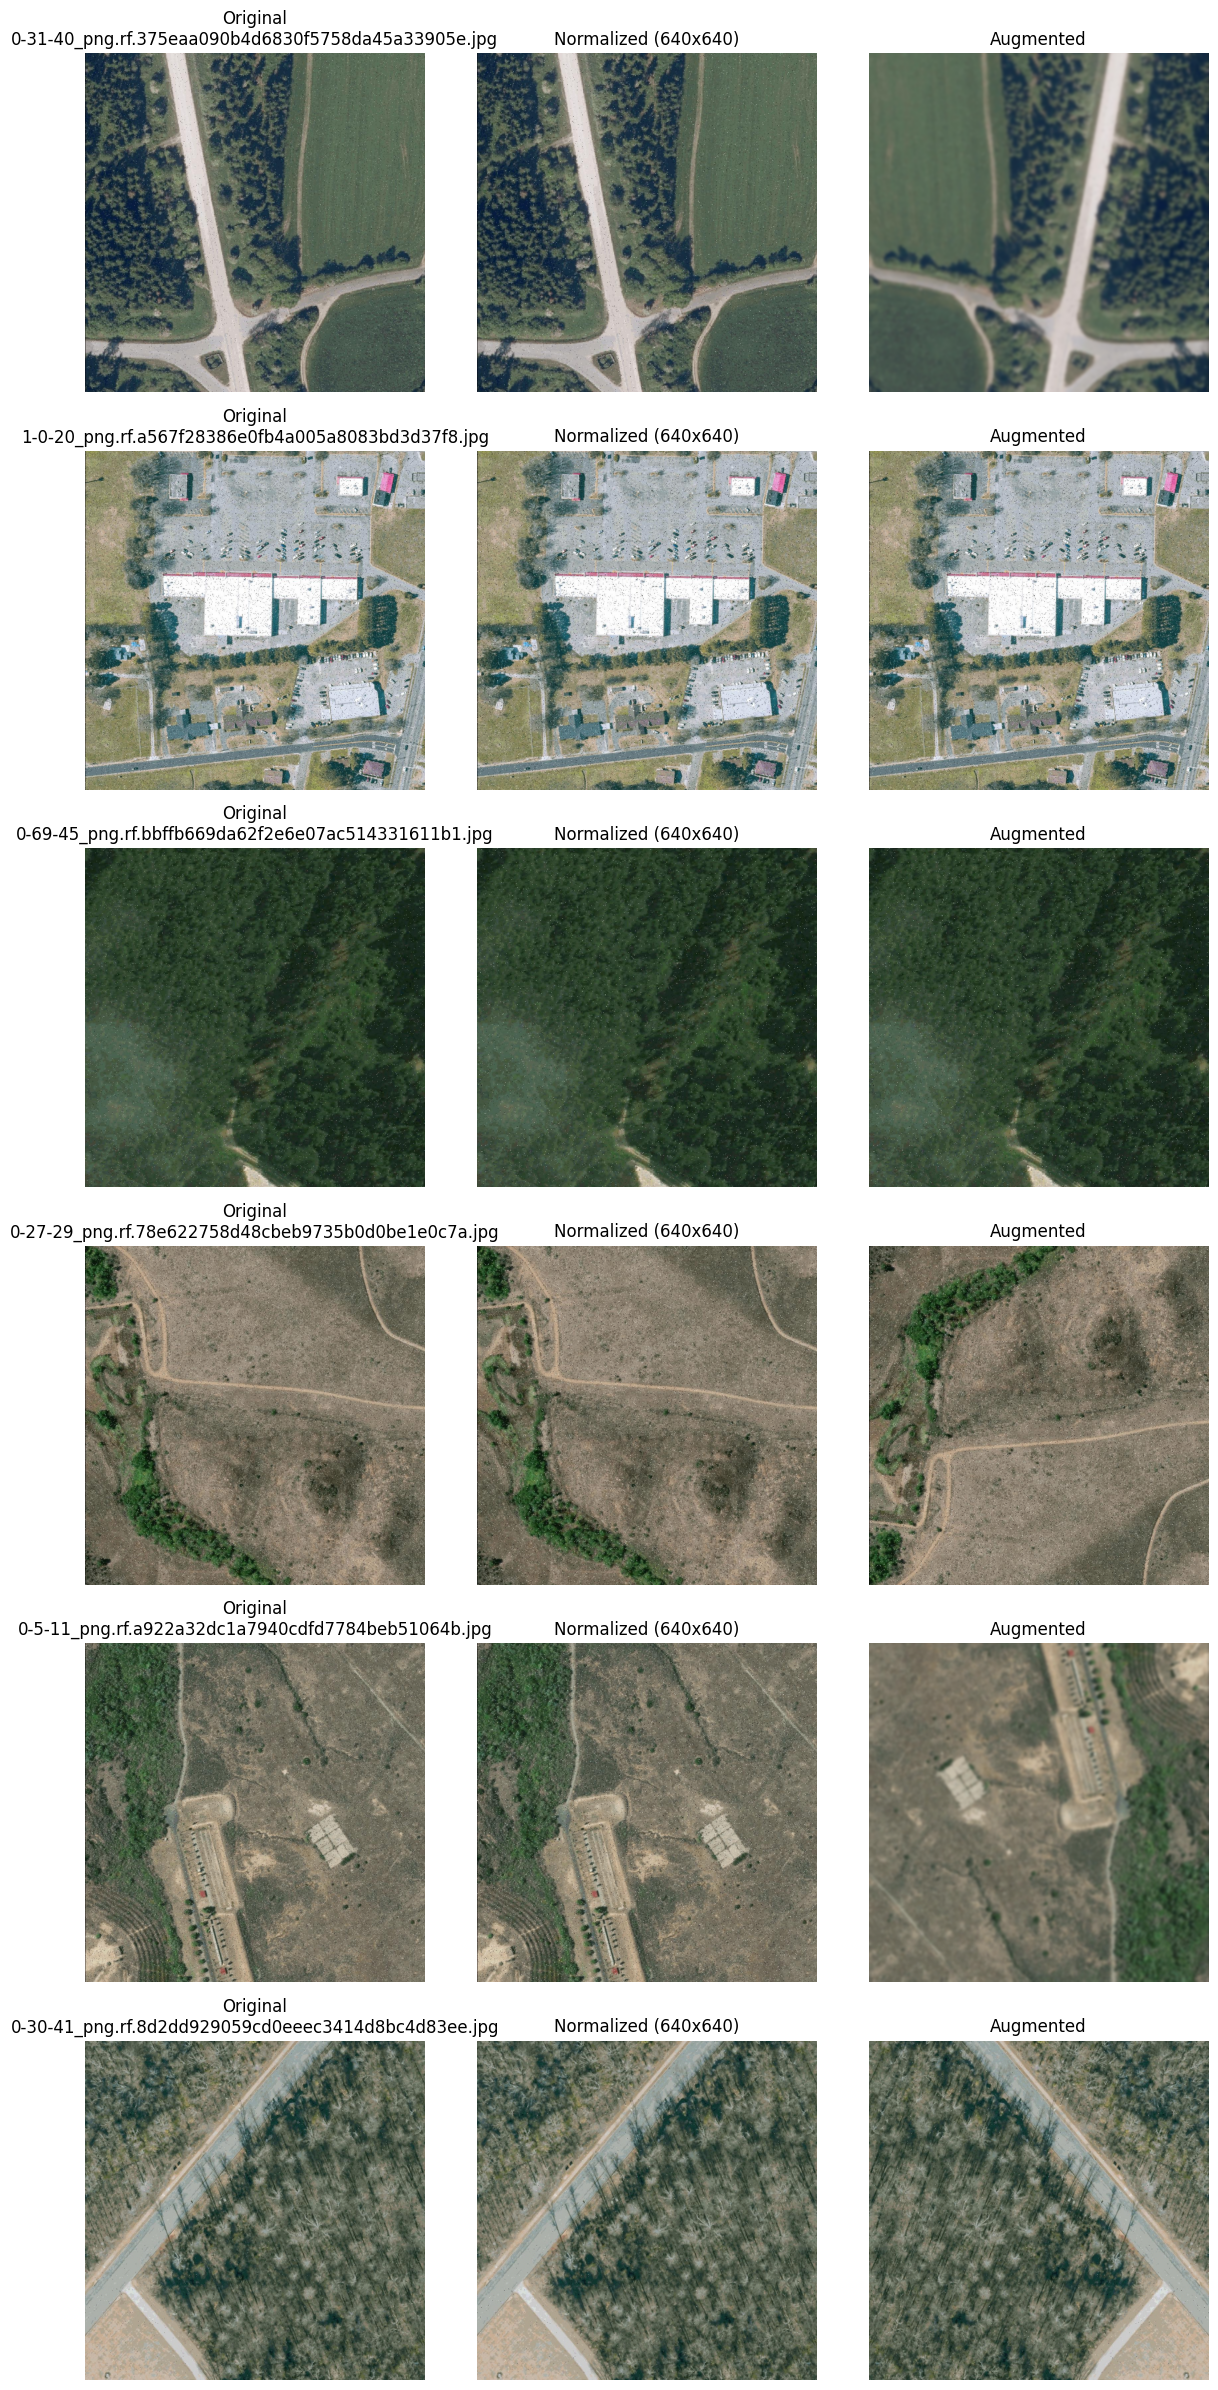

In [7]:
import cv2, matplotlib.pyplot as plt
import albumentations as A
import os, random

# Path to training images
train_path = "/content/dataset/train/images"
sample_images = random.sample(os.listdir(train_path), 6)  # pick 6 random images

# Define augmentation pipeline
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.RandomBrightnessContrast(p=0.3),
    A.GaussianBlur(p=0.2),
])

# Plot setup
fig, axes = plt.subplots(len(sample_images), 3, figsize=(12, 4*len(sample_images)))

for i, img_name in enumerate(sample_images):
    img_path = os.path.join(train_path, img_name)
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Resize + Normalize
    img_resized = cv2.resize(img_rgb, (640, 640))
    img_norm = (img_resized / 255.0)

    # Apply Augmentation
    aug = transform(image=img_resized)
    aug_img = aug["image"]

    # Show Original | Normalized | Augmented
    axes[i,0].imshow(img_rgb)
    axes[i,0].set_title(f"Original\n{img_name}")
    axes[i,0].axis("off")

    axes[i,1].imshow(img_norm)
    axes[i,1].set_title("Normalized (640x640)")
    axes[i,1].axis("off")

    axes[i,2].imshow(aug_img)
    axes[i,2].set_title("Augmented")
    axes[i,2].axis("off")

plt.tight_layout()
plt.show()

In [10]:
import rasterio
import numpy as np

tif_path = "/content/drive/MyDrive/sample_satellite.tif"  # if you have a .tif file
if os.path.exists(tif_path):
    with rasterio.open(tif_path) as src:
        img_array = src.read([1,2,3])  # RGB bands
        img_array = np.moveaxis(img_array, 0, -1)

    plt.imshow(img_array)
    plt.title("Satellite Image (RGB)")
    plt.axis("off")
    plt.show()

In [11]:
from sklearn.cluster import KMeans

if 'img_array' in locals():
    pixels = img_array.reshape(-1, 3)
    kmeans = KMeans(n_clusters=3, random_state=42).fit(pixels)
    clustered = kmeans.labels_.reshape(img_array.shape[:2])

    plt.imshow(clustered, cmap="tab20")
    plt.title("Clustered Regions (KMeans)")
    plt.axis("off")
    plt.show()

In [12]:
!yolo segment train model=yolov8s-seg.pt data=/content/dataset/data.yaml epochs=100 imgsz=640

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics 8.3.204 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/dataset/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fa